 # Claim Analysis and Visualization

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patheffects import withStroke
import plot_info

In [2]:
# Load data
df = pd.read_csv('preprocessed_data/claims_db_truncated_for_llm.csv')
df["assessment_type"].unique()

array([nan, 'Not assessed', 'Verified', 'Mixed', 'Unchallenged',
       'Unchallenged, logically consistent', 'Partially verified',
       'Challenged', 'Unchallenged, logically inconsistent',
       'Challenged by reproducibility project',
       'Challenged by same authors', 'Verified by same authors',
       'Verified by reproducibility project', 'Reproduction in progress'],
      dtype=object)

In [3]:
df[["assertion_type"]].value_counts()

assertion_type    
assessment            6423
evidence              3886
major_claim           1006
minor_claim            590
main_claim             400
reference              399
method                 393
comment                148
additional_context      54
Name: count, dtype: int64

In [4]:
major_claims_df = df[df['assertion_type'] == 'major_claim']
print(len(major_claims_df))
major_claims_df

1006


,content,article_id,rank,pmid,authors_txt,title,pmid_article,volume,issue,abstract,...,journal_name,impact_factor,first_author_extracted,last_author_extracted,primary_affiliation,assertion_type,label,is_assessed,assessment_type,rank_assessment_type
8,#gene:FBgn0000279 is...,3103.0,2,NaN,Tryselius Y;Samakovl...,"CecC, a cecropin gen...",1740152.0,204,1,Cecropins are antiba...,...,European journal of biochemistry,5.4,Tryselius Y,Hultmark D,Department of Microb...,major_claim,Major claim,True,Verified,1.0
30,Hemocyte proliferati...,2204.0,3,NaN,Zettervall CJ;Anderl...,A directed screen fo...,15381778.0,101,39,An attack by a paras...,...,Proceedings of the National Academy of Science...,11.1,Zettervall CJ,Hultmark D,Umeå Centre for Mole...,major_claim,Major claim,True,Verified,1.0
31,The Ras/MAPK pathway...,2204.0,1,NaN,Zettervall CJ;Anderl...,A directed screen fo...,15381778.0,101,39,An attack by a paras...,...,Proceedings of the National Academy of Science...,11.1,Zettervall CJ,Hultmark D,Umeå Centre for Mole...,major_claim,Major claim,True,Verified,1.0
37,The JAK/STAT and JNK...,2204.0,2,NaN,Zettervall CJ;Anderl...,A directed screen fo...,15381778.0,101,39,An attack by a paras...,...,Proceedings of the National Academy of Science...,11.1,Zettervall CJ,Hultmark D,Umeå Centre for Mole...,major_claim,Major claim,True,Verified,1.0
110,#gene:FBgn0035976 fu...,2520.0,2,NaN,Gottar M;Gobert V;Mi...,The Drosophila immun...,11912488.0,416,6881,The antimicrobial de...,...,Nature,64.8,Gottar M,Royet J,UPR 9022 du Centre N...,major_claim,Major claim,True,Verified,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13261,Ehrlichia chaffeensi...,1593.0,1,NaN,Luce-Fedrow A;Von Oh...,Ehrlichia chaffeensi...,19687202.0,77,11,Ehrlichia chaffeensi...,...,Infection and immunity,3.1,Luce-Fedrow A,Chapes SK,Kansas State Univers...,major_claim,Major claim,True,"Unchallenged, logically consistent",6.0
13264,B. bassiana inhibits...,1532.0,2,NaN,Matskevich AA;Quinti...,The Drosophila PRR G...,20201042.0,40,5,The Drosophila Toll-...,...,European journal of immunology,5.4,Matskevich AA,Ferrandon D,Equipe Fondation Rec...,major_claim,Major claim,True,"Unchallenged, logically consistent",6.0
13270,A polyclonal antibod...,3004.0,2,NaN,Georgel P;Kappler C;...,Drosophila immunity....,7537872.0,23,7,Bacterial challenge ...,...,Nucleic acids research,14.9,Georgel P,Hoffmann JA,Institut de Biologie...,major_claim,Major claim,True,"Unchallenged, logically inconsistent",7.0
13273,A pathway in additio...,2874.0,3,NaN,Wu LP;Anderson KV,Regulated nuclear im...,9510254.0,392,6671,The Drosophila immun...,...,Nature,64.8,Wu LP,Anderson KV,Molecular Biology Pr...,major_claim,Major claim,True,"Unchallenged, logically inconsistent",7.0


In [5]:
major_claims_df[["assessment_type"]].value_counts()

assessment_type                      
Verified                                 559
Unchallenged, logically consistent       111
Unchallenged                             107
Partially verified                        75
Verified by same authors                  44
Challenged by reproducibility project     38
Challenged                                26
Unchallenged, logically inconsistent      22
Mixed                                     12
Verified by reproducibility project        7
Challenged by same authors                 5
Name: count, dtype: int64

In [6]:
# Apply categorizations - using .loc to avoid SettingWithCopyWarning
major_claims_df.loc[:, 'journal_category'] = major_claims_df['impact_factor'].apply(plot_info.categorize_journal)
major_claims_df.loc[:, 'assessment_group'] = major_claims_df['assessment_type'].apply(plot_info.group_assessment)

# Display distribution of journal categories
print(f"Journal Category Distribution:")
print(major_claims_df['journal_category'].value_counts())
print("\nAssessment Group Distribution:")
print(major_claims_df['assessment_group'].value_counts())


Journal Category Distribution:
journal_category
Low Impact         635
High Impact        309
Trophy Journals     62
Name: count, dtype: int64

Assessment Group Distribution:
assessment_group
Verified              610
Unchallenged          240
Partially Verified     75
Challenged             69
Mixed                  12
Name: count, dtype: int64


/var/folders/pj/15hxgl0j1wg2w_t5k7bvnq5c0000gn/T/ipykernel_70052/892573795.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  major_claims_df.loc[:, 'journal_category'] = major_claims_df['impact_factor'].apply(plot_info.categorize_journal)
/var/folders/pj/15hxgl0j1wg2w_t5k7bvnq5c0000gn/T/ipykernel_70052/892573795.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  major_claims_df.loc[:, 'assessment_group'] = major_claims_df['assessment_type'].apply(plot_info.group_assessment)


In [7]:
unique_pairs = major_claims_df[["journal_name", "impact_factor"]].drop_duplicates().sort_values("impact_factor", ascending=False)
for index, row in unique_pairs.iterrows():
    # Count occurrences of this journal in major_claims
    count = len(major_claims_df[major_claims_df["journal_name"] == row["journal_name"]])
    print(f"{row['impact_factor']:.1f}\t{row['journal_name']} ({count} claims)")


64.8	Nature (20 claims)
64.5	Cell (15 claims)
56.9	Science (New York, N.Y.) (27 claims)
32.4	Immunity (24 claims)
30.5	Nature immunology (28 claims)
30.3	Cell host & microbe (11 claims)
16.0	Molecular cell (8 claims)
14.9	Nucleic acids research (11 claims)
14.8	Nature protocols (1 claims)
11.8	Developmental cell (24 claims)
11.4	The EMBO journal (56 claims)
11.1	Proceedings of the National Academy of Sciences of the United States of America (119 claims)
10.5	Genes & development (25 claims)
10.3	National Cancer Institute monograph (2 claims)
9.8	PLoS biology (19 claims)
9.3	Experientia (1 claims)
9.2	Current biology : CB (36 claims)
9.1	EMBO reports (31 claims)
7.8	The Journal of cell biology (1 claims)
7.8	The Journal of biophysical and biochemical cytology (2 claims)
7.8	Aging cell (6 claims)
7.0	Molecular & cellular proteomics : MCP (3 claims)
6.9	Journal of experimental botany (2 claims)
6.7	PLoS pathogens (40 claims)
5.8	Microbes and infection (7 claims)
5.6	Journal of molecular bi

In [8]:
major_claims_df

,content,article_id,rank,pmid,authors_txt,title,pmid_article,volume,issue,abstract,...,first_author_extracted,last_author_extracted,primary_affiliation,assertion_type,label,is_assessed,assessment_type,rank_assessment_type,journal_category,assessment_group
8,#gene:FBgn0000279 is...,3103.0,2,NaN,Tryselius Y;Samakovl...,"CecC, a cecropin gen...",1740152.0,204,1,Cecropins are antiba...,...,Tryselius Y,Hultmark D,Department of Microb...,major_claim,Major claim,True,Verified,1.0,Low Impact,Verified
30,Hemocyte proliferati...,2204.0,3,NaN,Zettervall CJ;Anderl...,A directed screen fo...,15381778.0,101,39,An attack by a paras...,...,Zettervall CJ,Hultmark D,Umeå Centre for Mole...,major_claim,Major claim,True,Verified,1.0,High Impact,Verified
31,The Ras/MAPK pathway...,2204.0,1,NaN,Zettervall CJ;Anderl...,A directed screen fo...,15381778.0,101,39,An attack by a paras...,...,Zettervall CJ,Hultmark D,Umeå Centre for Mole...,major_claim,Major claim,True,Verified,1.0,High Impact,Verified
37,The JAK/STAT and JNK...,2204.0,2,NaN,Zettervall CJ;Anderl...,A directed screen fo...,15381778.0,101,39,An attack by a paras...,...,Zettervall CJ,Hultmark D,Umeå Centre for Mole...,major_claim,Major claim,True,Verified,1.0,High Impact,Verified
110,#gene:FBgn0035976 fu...,2520.0,2,NaN,Gottar M;Gobert V;Mi...,The Drosophila immun...,11912488.0,416,6881,The antimicrobial de...,...,Gottar M,Royet J,UPR 9022 du Centre N...,major_claim,Major claim,True,Verified,1.0,Trophy Journals,Verified
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13261,Ehrlichia chaffeensi...,1593.0,1,NaN,Luce-Fedrow A;Von Oh...,Ehrlichia chaffeensi...,19687202.0,77,11,Ehrlichia chaffeensi...,...,Luce-Fedrow A,Chapes SK,Kansas State Univers...,major_claim,Major claim,True,"Unchallenged, logically consistent",6.0,Low Impact,Unchallenged
13264,B. bassiana inhibits...,1532.0,2,NaN,Matskevich AA;Quinti...,The Drosophila PRR G...,20201042.0,40,5,The Drosophila Toll-...,...,Matskevich AA,Ferrandon D,Equipe Fondation Rec...,major_claim,Major claim,True,"Unchallenged, logically consistent",6.0,Low Impact,Unchallenged
13270,A polyclonal antibod...,3004.0,2,NaN,Georgel P;Kappler C;...,Drosophila immunity....,7537872.0,23,7,Bacterial challenge ...,...,Georgel P,Hoffmann JA,Institut de Biologie...,major_claim,Major claim,True,"Unchallenged, logically inconsistent",7.0,High Impact,Unchallenged
13273,A pathway in additio...,2874.0,3,NaN,Wu LP;Anderson KV,Regulated nuclear im...,9510254.0,392,6671,The Drosophila immun...,...,Wu LP,Anderson KV,Molecular Biology Pr...,major_claim,Major claim,True,"Unchallenged, logically inconsistent",7.0,Trophy Journals,Unchallenged


In [9]:
major_claims_df[["journal_category", "journal_name"]][major_claims_df["journal_category"] == "Trophy Journals"]["journal_name"].value_counts()

journal_name
Science (New York, N.Y.)    27
Nature                      20
Cell                        15
Name: count, dtype: int64

 ## Plot Functions

 ## Analysis and Visualization

 ### Journal Category Analysis

In [10]:
def create_journal_claims_table(df):
    """
    Create a table with journal name, impact factor, and counts for each claim type
    
    Parameters:
    - df: DataFrame containing the claims data
    
    Returns:
    - A DataFrame with journal information and claim counts
    """
    # Make a copy of the dataframe to avoid modifying the original
    df_copy = df.copy()
    
    # Map detailed assessment types to standardized categories
    df_copy['standard_category'] = df_copy['assessment_type'].map(
        lambda x: plot_info.category_mapping.get(x, x)
    )
    
    # Group by journal name and impact factor
    grouped = df_copy.groupby(['journal_name', 'impact_factor'])['standard_category'].value_counts().unstack().fillna(0)
    
    # Convert counts to integers
    for col in grouped.columns:
        grouped[col] = grouped[col].astype(int)
    
    # Create a total count column
    grouped['Total'] = grouped.sum(axis=1)
    
    # Sort by impact factor (descending)
    grouped = grouped.sort_values(by='impact_factor', ascending=False)
    
    # Ensure all required columns exist
    required_columns = ['Challenged', 'Mixed', 'Partially Verified', 'Unchallenged', 'Verified', 'Total']
    for col in required_columns:
        if col not in grouped.columns:
            grouped[col] = 0
    
    # Reorder columns
    grouped = grouped[required_columns]
    
    # Reset index to make journal_name and impact_factor regular columns
    grouped = grouped.reset_index()
    
    return grouped

# Apply the function to generate the table
journal_claims_table = create_journal_claims_table(major_claims_df)

journal_claims_table.to_csv("figures/tableS1_claims_by_journal.csv", index=False)


Using 1006 of 1006 rows
Using 1006 of 1006 rows


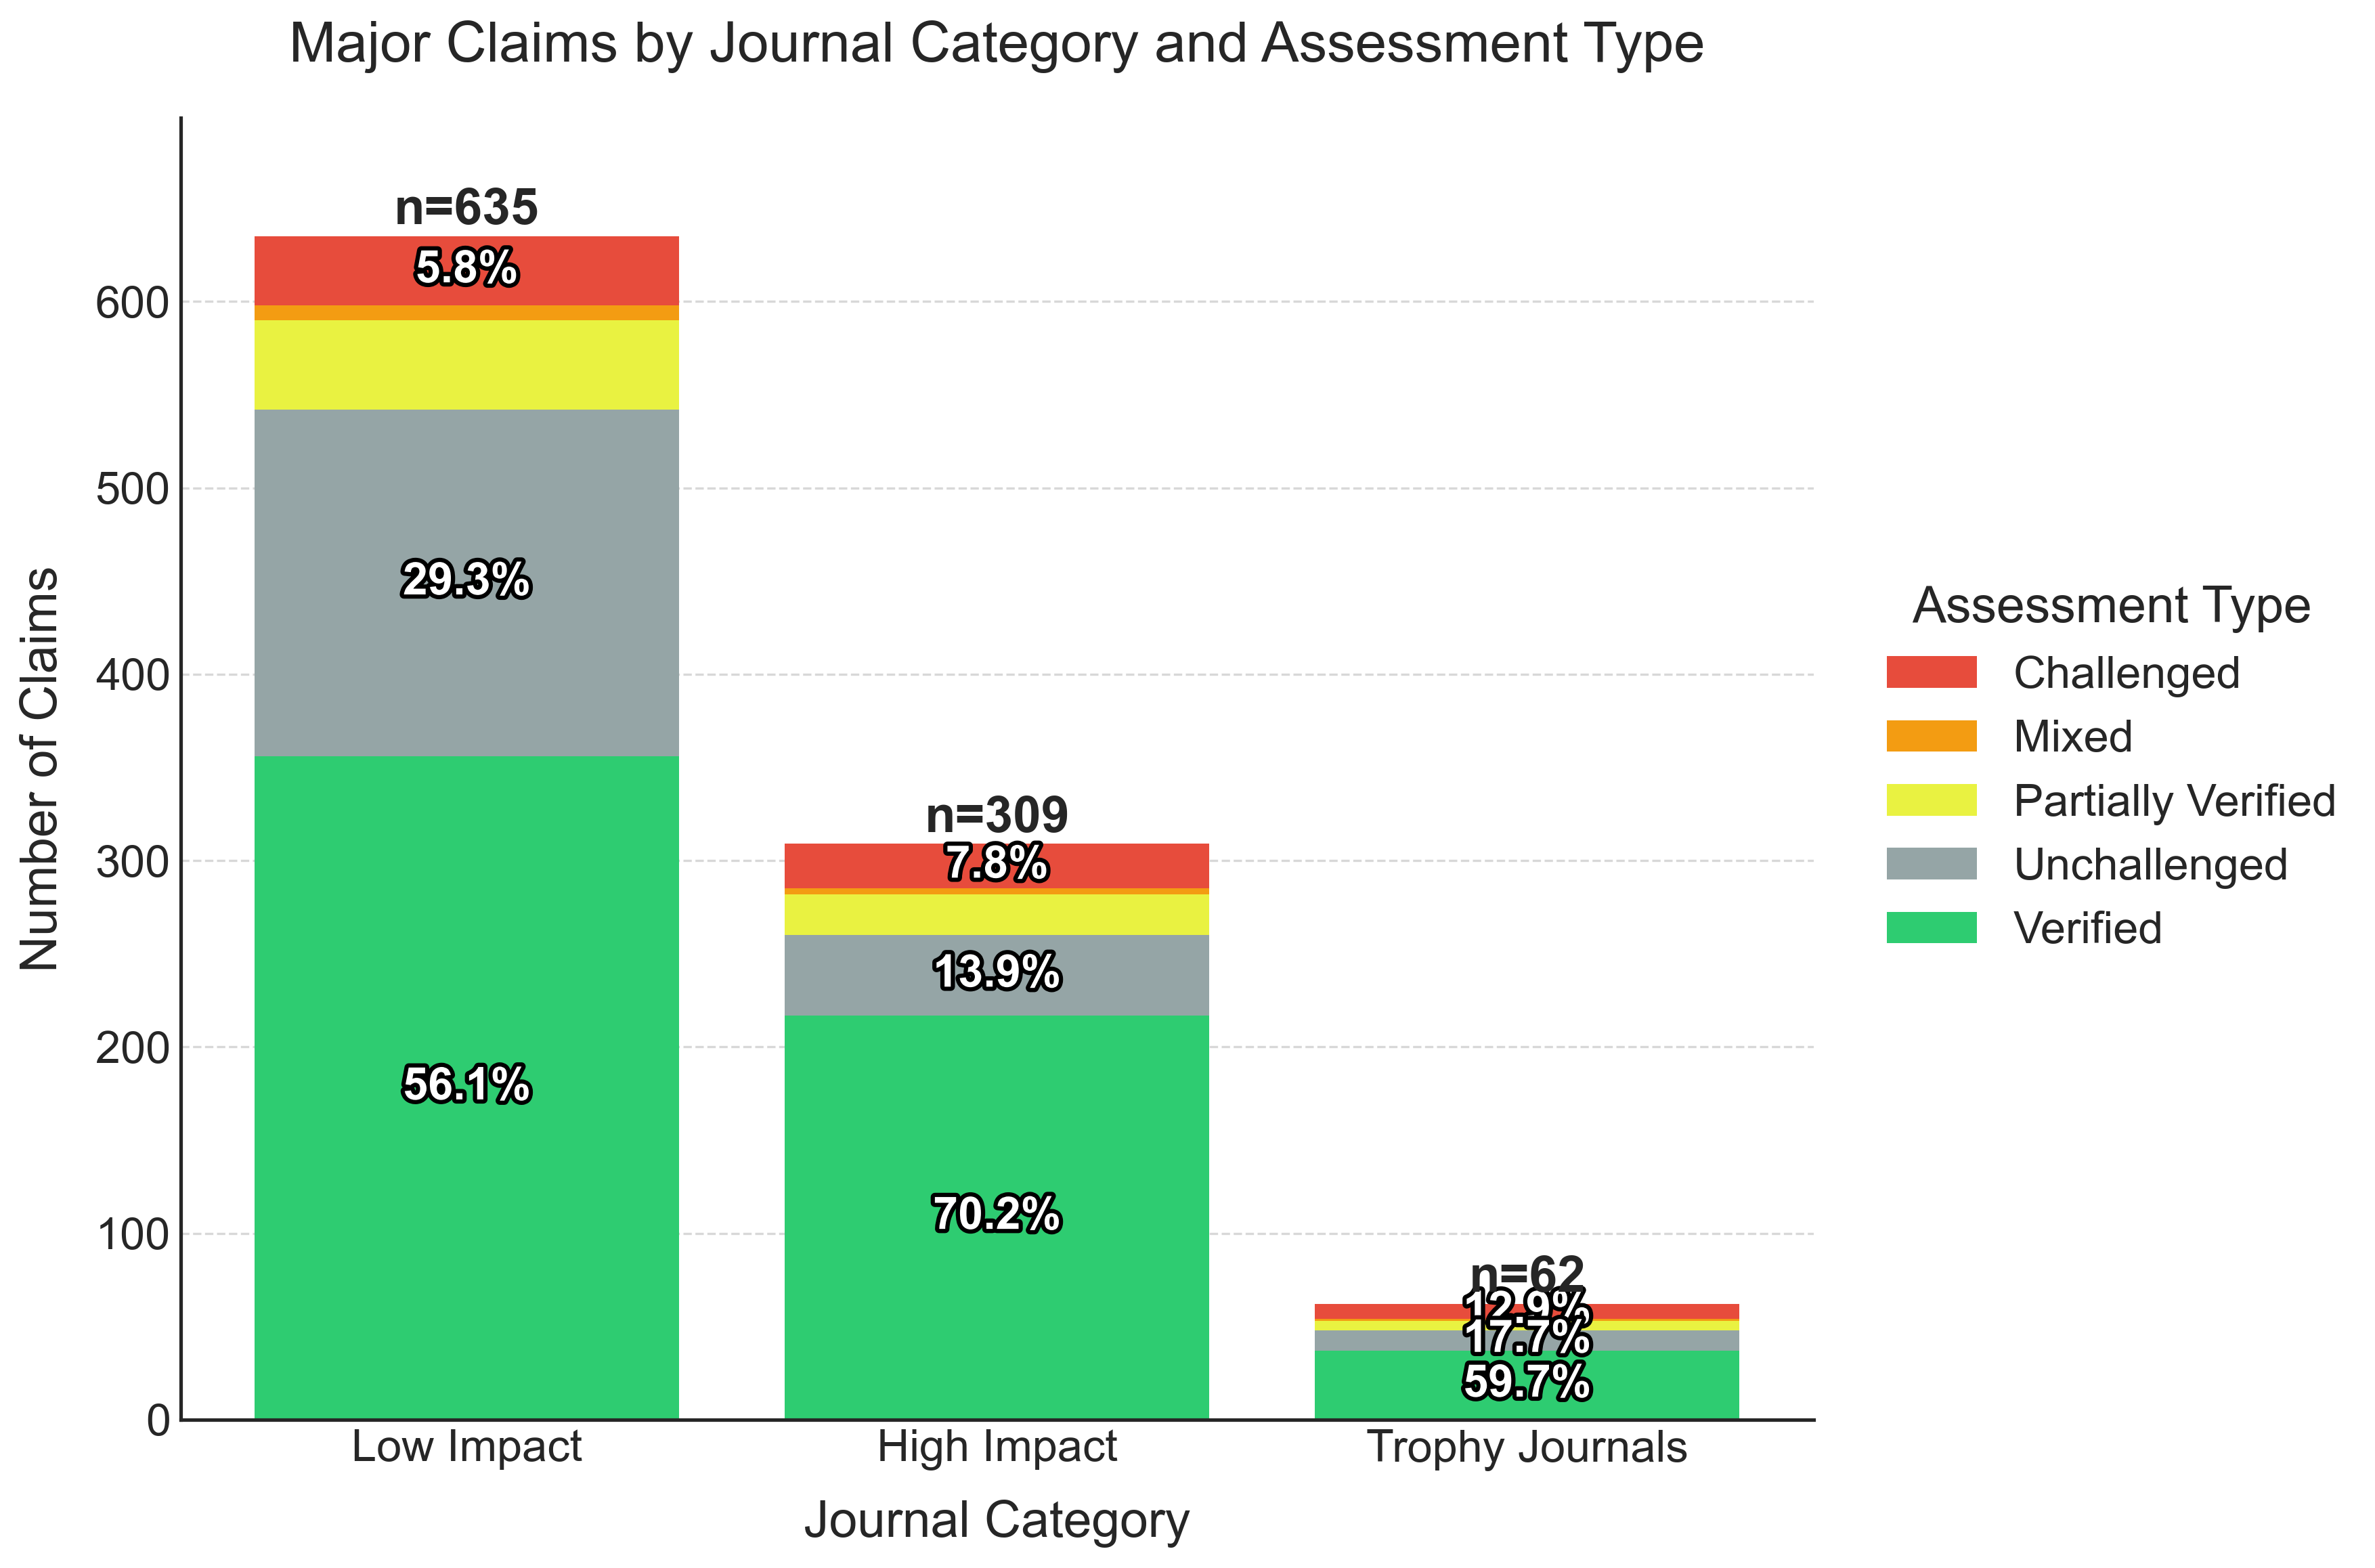

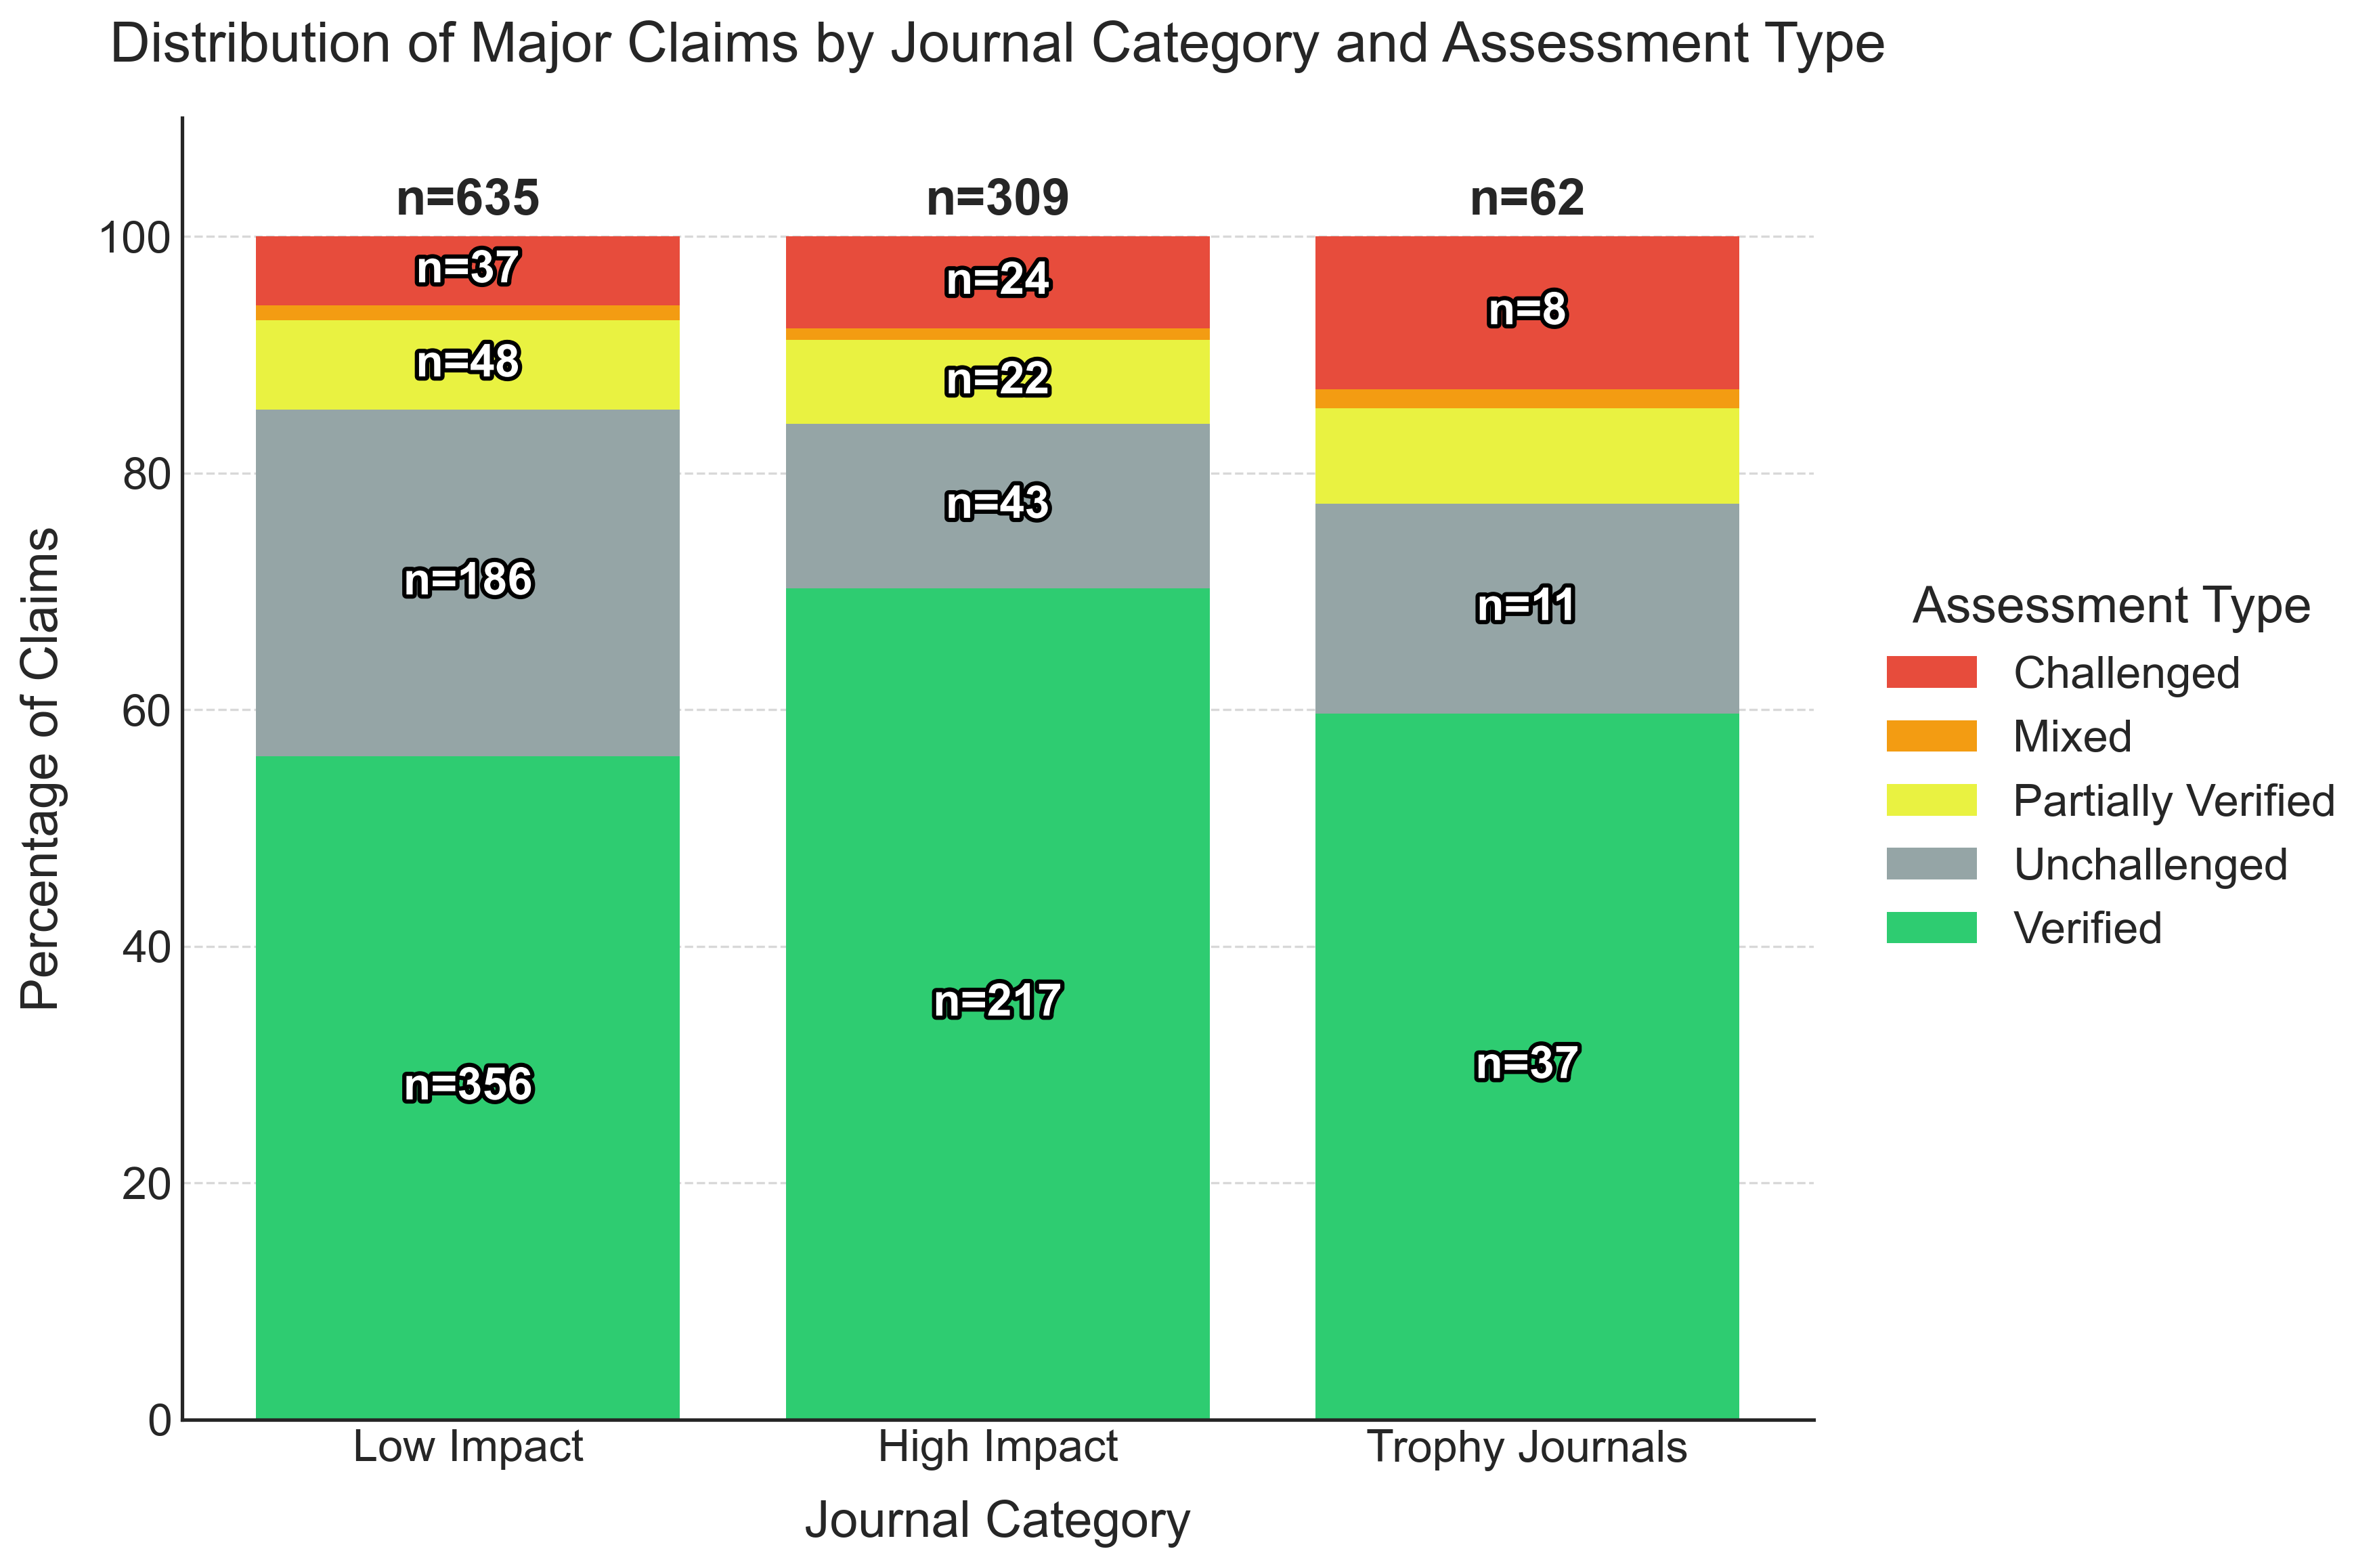

In [11]:
# Generate and save journal category plots
fig1, ax1 = plot_info.create_stacked_bar_plot(major_claims_df, mode='absolute', by_time=False, use_expanded=False)
plt.savefig('figures/fig2A_claims_journal_absolute.png', dpi=300, bbox_inches='tight')

#plt.savefig('figures/fig2_claims_journal_absolute.pdf', bbox_inches='tight')

fig2, ax2 = plot_info.create_stacked_bar_plot(major_claims_df, mode='percentage', by_time=False, use_expanded=False)
plt.savefig('figures/fig2B_claims_journal_percentage.png', dpi=300, bbox_inches='tight')
#plt.savefig('figures/fig2_claims_journal_percentage.pdf', bbox_inches='tight')



 ### Time Period Analysis

Using 1006 of 1006 rows
Using 1006 of 1006 rows


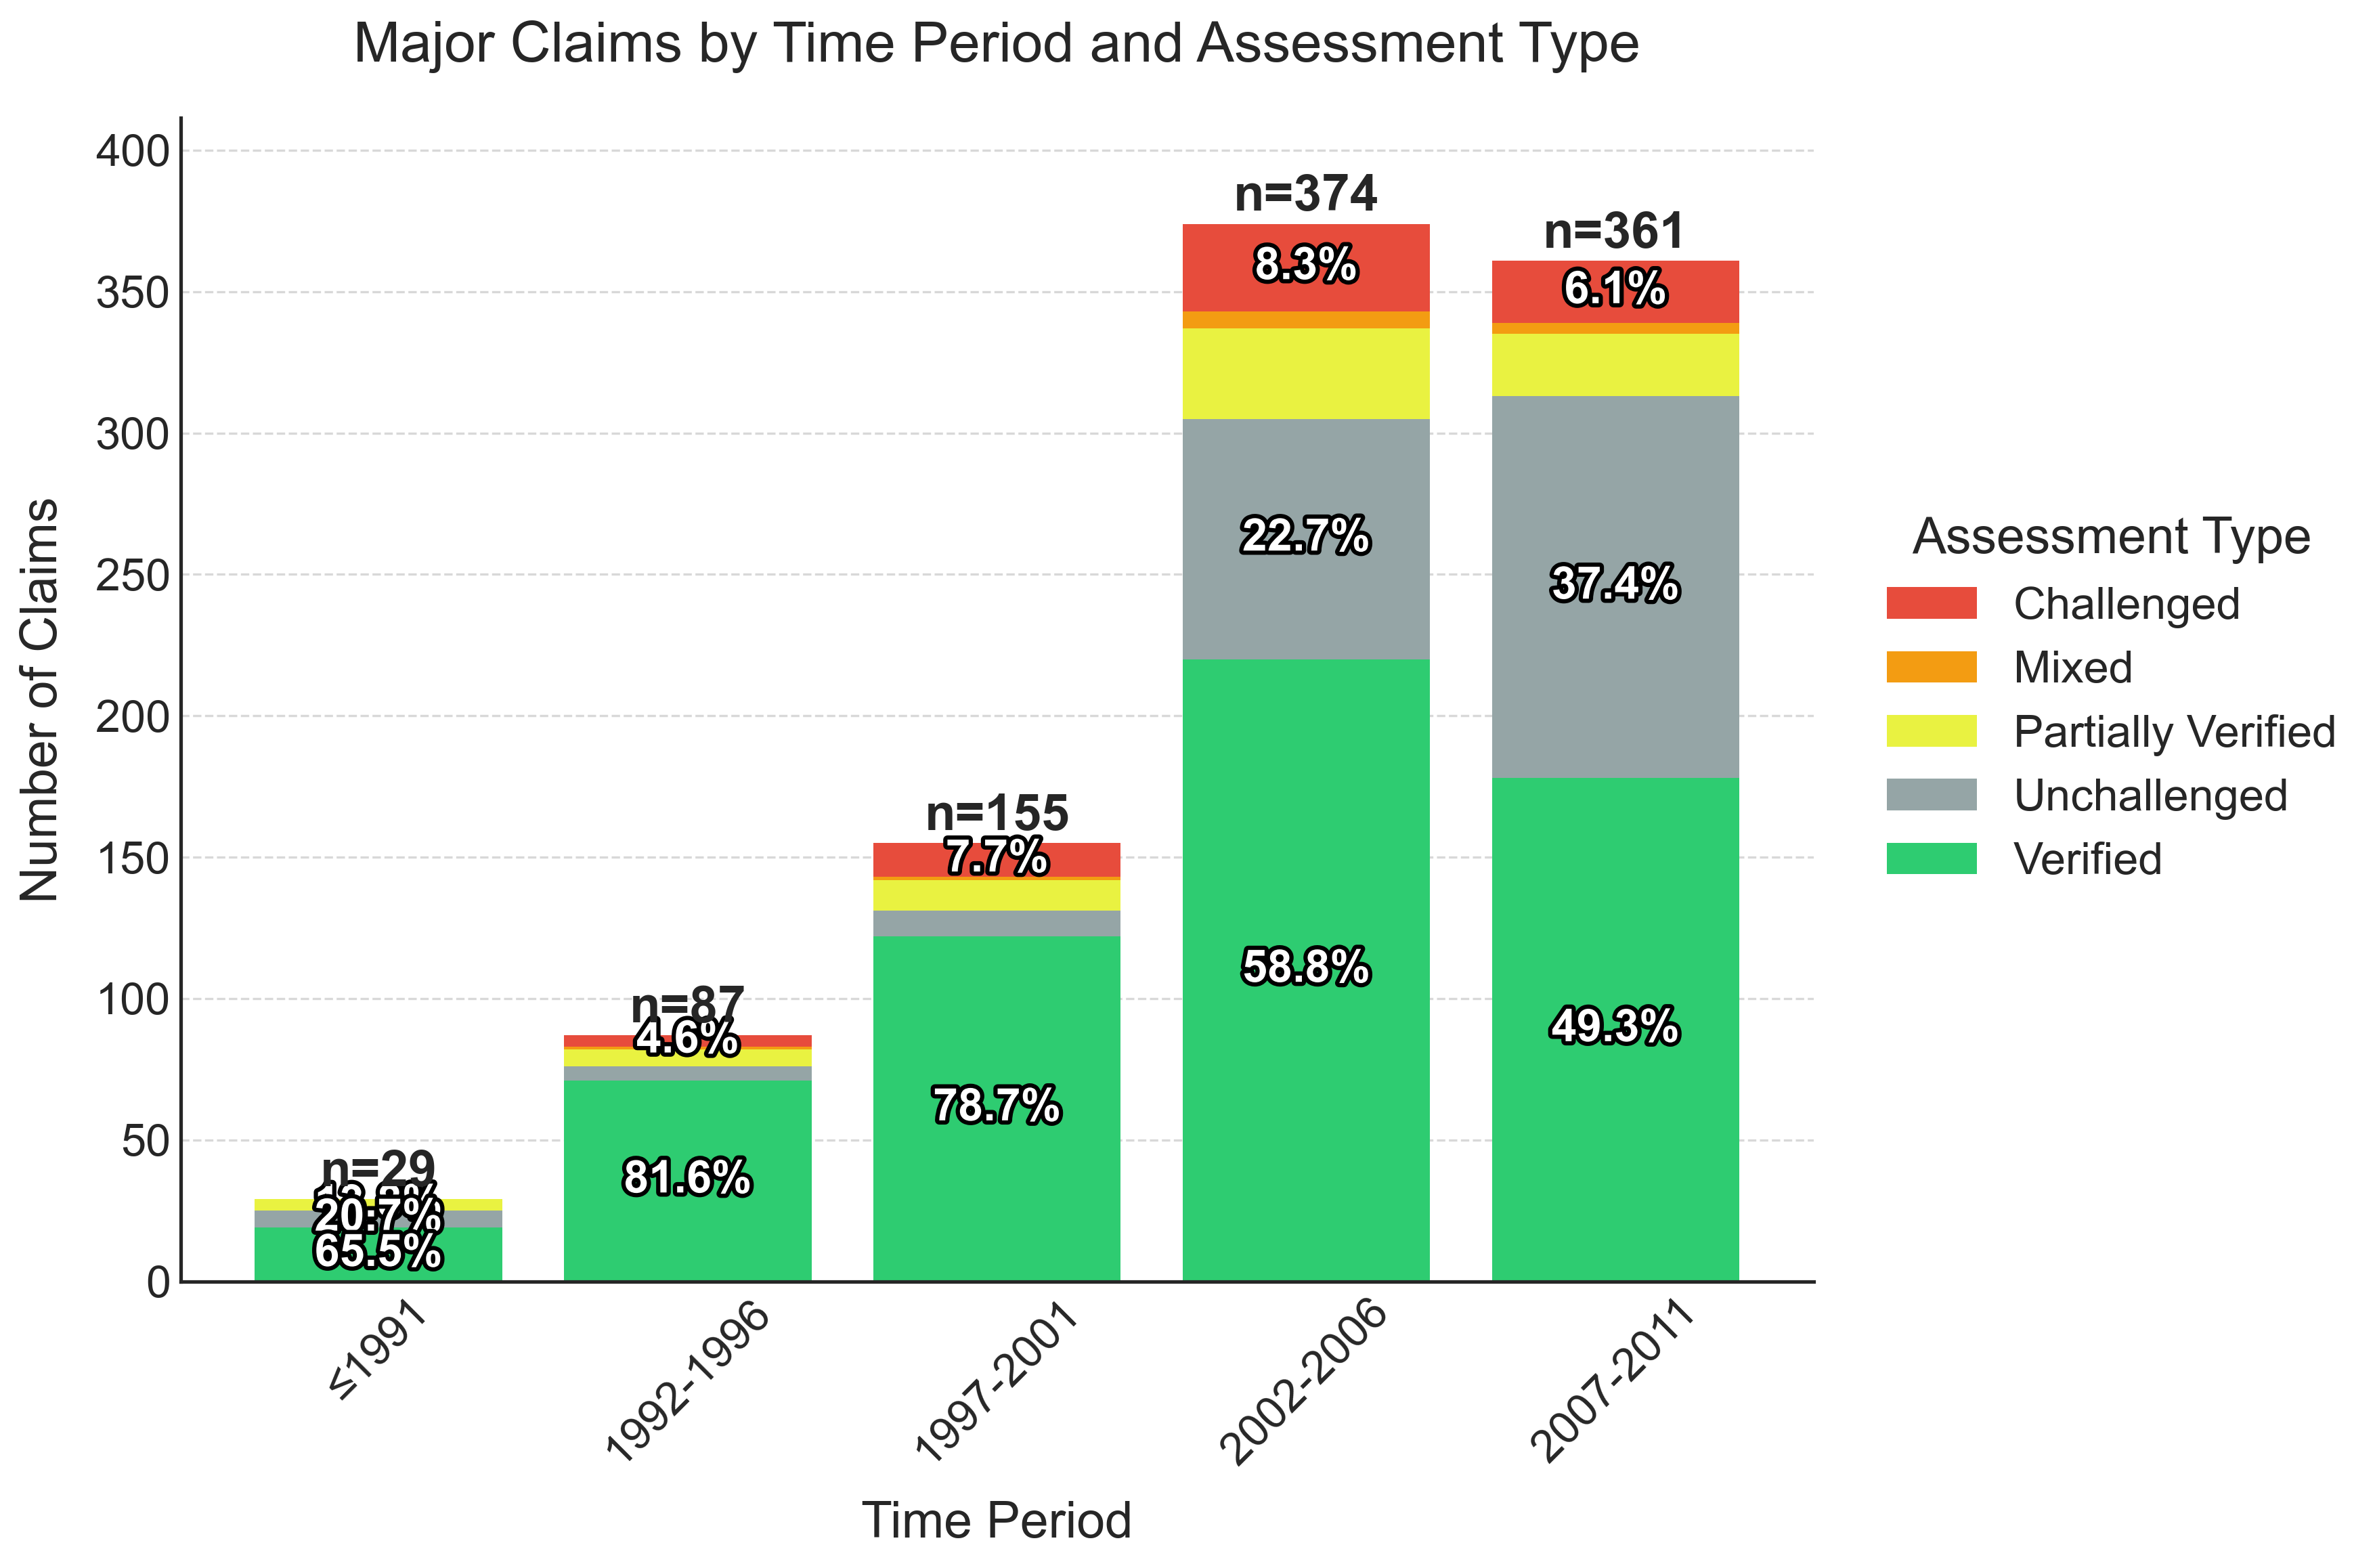

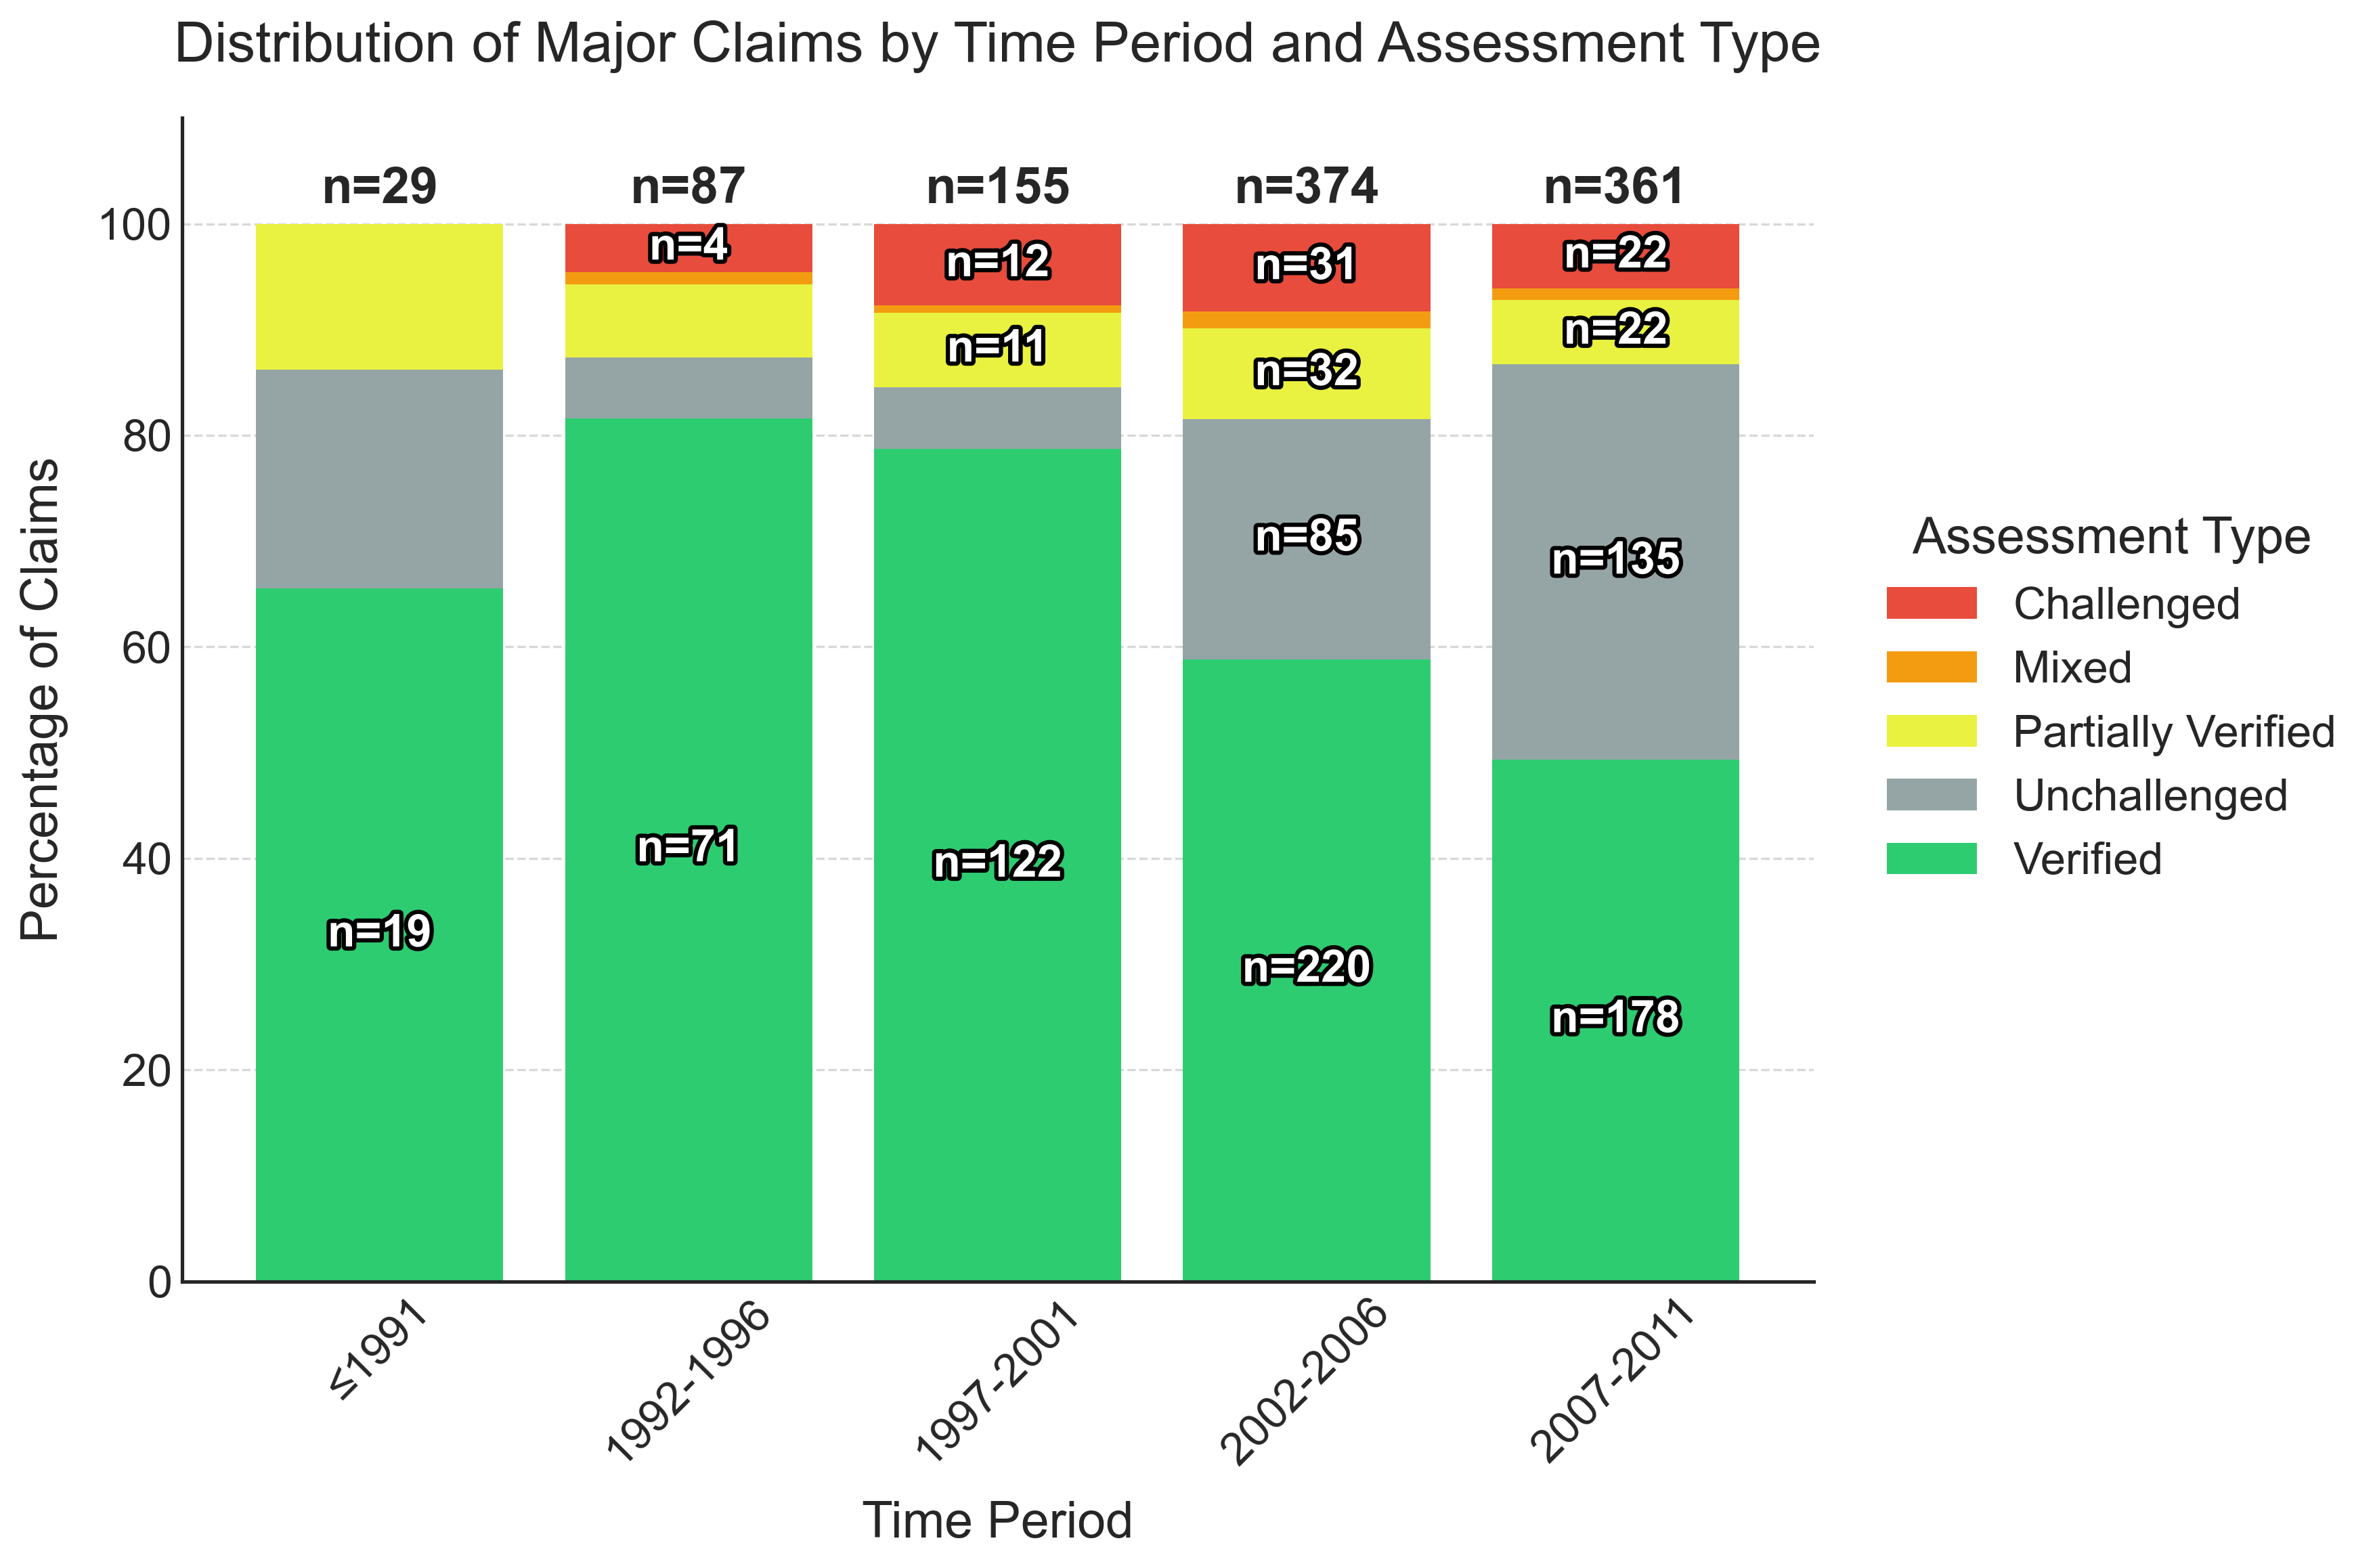

In [12]:
# Generate and save time period plots
fig3, ax3 = plot_info.create_stacked_bar_plot(major_claims_df, mode='absolute', by_time=True)
plt.savefig('figures/fig3A_claims_time_absolute.png', dpi=300, bbox_inches='tight')
#plt.savefig('figures/claims_time_absolute.pdf', bbox_inches='tight')

fig4, ax4 = plot_info.create_stacked_bar_plot(major_claims_df, mode='percentage', by_time=True)
plt.savefig('figures/fig3B_claims_time_percentage.png', dpi=300, bbox_inches='tight')
#plt.savefig('figures/claims_time_percentage.pdf', bbox_inches='tight')


 ### Trophy Journals Analysis

 ## Figure 1 Sankey Diagra,

In [13]:
# Create Sankey diagram
to_plot = major_claims_df[["assertion_type", "label", "assessment_type", "rank_assessment_type"]]
fig = plot_info.create_sankey_diagram(to_plot)
fig.show()
fig.write_html('figures/fig1_claims_sankey.html')